### Advection-Dispersion Model for Solute Transport through a Column
David J. Lampert, PhD, PE  

Laboratory columns are widely used to study the fate and transport of solutes in porous media. Tracer studies are often performed on columns to assess their flow properties, including their velocity and dispersion coefficient. Tracers are needed before columns can be used to study chemical processes in the column media to separate out the flow effects. This notebook provides a simulation tool for the flow a non-reactive tracer through a column. 

**Quick start:** The notebook can be used by running the first code block to import functions and define parameters, then running the block to get the eigenvalues, then running the concentration calculator at the end.

#### Model Problem
Imagine that a 30-cm long column (a cylinder) has been set up with flow entering on one end and exiting on the other end. The velocity of the column is 10 cm/hr and the disperion coefficient is 100 cm$^{2}$/hr. Note that tracers are used to estimate these properties, but in this example, it is assumed that the parameter values are known. If the solute concentration in the influent for a tracer such as bromide is set to 100 mg/L, eventually the concentration leaving the column will have to reach 100 mg/L also. But what about beforehand? the concentration should start at zero and then increase eventually to the influent concentration level. To assess the flow properties, a mass transport model is needed. The diagram illustrates the model problem and the expected solution. The goal is to find a mathematical expression to estimate the breakthrough curve for this column.

<img src='column_effluent.png' width = 400>

The parameters that affect the output from the column for this model include:

|Parameter|Description|
|:-|:----|
|$C_{0}$|Solute influent concentration ($ML^{-3}$)|  
|$U$|Flow velocity in column ($LT^{-1}$)|  
|$D$|Dispersion coefficient ($L^{2} T^{-1}$)|  
|$L$|Length of column ($L$)|  

The code below defines the values of the function and imports key Python libraries that are used subsequently. 

In [224]:
# Define the parameter values in Python
C0 = 100  # mg/L
U  = 10   # cm/hr
D  = 100  # cm2/hr
L  = 30   # cm
n  = 100  # number of terms to use in series solution

# Import Numeric Python for array calculations and other math functions
import numpy as np

# Import Matplotlib for plotting the results
from matplotlib import pyplot as plt, lines

# Import the Scientific Python optimization library
from scipy import optimize

### Governing Equations and Auxiliary Conditions
The governing equation for advection and dispersion of a solute in one dimension is:

$\frac{dC}{dt}=D\frac{d^{2}C}{dx^{2}}-U\frac{dC}{dx}$  

Two boundary conditions and one initial conditions are required to solve the equation. Assuming there is no tracer in the column at the start of the simulation, the iniital condition is zero concentration.

$C(x,t=0)=0$

The boundary condition for the influent is flux-matching, with advective flux into the colum matching the advective and dispersive fluxes at the start of the column.

$UC_{0}=UC(x=0,t)-D\frac{dc(x=0,t)}{dx}$

The boundary condition at the effluent is normally assumed that the disperion flux is negligible, meaning the derivative is zero.

$\frac{dC(x=L,t)}{dx}=0$

### Non-dimensionalization
The equations can be non-dimensionalized in terms of dimensionless time $t^{*}$, distance $x^{*}$, and concentration $C^{*}$, which simplifies the mathematics. 

$t^{*}=\frac{Dt}{L^{2}}$  
$x^{*}=\frac{x}{L}$  
$C^{*}=\frac{C}{C_{0}}$  

In the dimensionless domain, the three parameters are reduced to just one parameter, defined as the Peclet number.  

$Pe$ = Ratio of advection to dispersion = $\frac{UL}{D}$

The governing equation and auxiliary conditions become:

$\frac{dC^{*}}{dt^{*}}=\frac{d^{2}C^{*}}{dx^{*2}}-Pe\frac{dC^{*}}{dx^{*}}$  

$C^{*}(x^{*},t^{*}=0)=0$  

$C^{*}(x^{*}=0,t^{*})-\frac{1}{Pe}\frac{dC^{*}(x^{*}=0,t^{*})}{dx^{*}}=1$  

$\frac{dC^{*}(x^{*}=1,t^{*})}{dx^{*}}=0$  

### Analytical Solution
The dimensionless governing equations and auxiliary conditions can be solved using [separation of variables](https://en.wikipedia.org/wiki/Separation_of_variables). The U.S. Geological Survey summarizes solutions for some important solute transport problems, including this one
[here](https://pubs.usgs.gov/twri/twri3-b7/pdf/TWRI_3-B7.pdf). The solution is:

$C^{*}(x^{*},t^{*})=1-2 \textrm{ } Pe \textrm{ } e^{ \left(\frac{Pe}{2}x^{*}-\frac{Pe^{2}}{4} t^{*} \right)} \displaystyle\sum_{n=1}^{\infty} 
\frac{\beta_{i} \left[ \beta_{i} cos\left(\beta_{i} x^{*}) \right) + \frac{Pe}{2}sin \left(\beta_{i} x^{*}\right) \right]}
{\left[\beta_{i}^{2} + \frac{Pe^{2}}{4} + Pe \right]
\left[\beta_{i}^{2} + \frac{Pe^{2}}{4} \right]} 
e^{-\beta_{i}^{2}t^{*}}$

The values of $\beta_{i}$ are the eigenvalues, and the corresponding terms in the infinite series are called eigenfunctions (see more description [here](http://tutorial.math.lamar.edu/Classes/DE/BVPEvals.aspx)). The eigenvalues are determined by finding the roots of the characteristic equation:

$\beta$ $cot \beta$ $- \frac{\beta^{2}}{Pe} + \frac{Pe}{4}=0$

### Model application
To apply the model, the eigenvalues must be estimated. The equation above has no exact solution, unlike some other characteristic equations that are commonly encountered in diffusion boundary value problems (e.g., $sin(\beta L) = 0$ has $\beta = \frac{n \pi}{L}$ with $n=1,2,3...$).  

The eigenvalues for a given column system with parameters $U$, $D$, and $C_{0}$ depend only on the Peclet number. The values for a given Peclet number can be determined by finding the roots of the function $F$:  

$F(Pe,\beta)=\beta \cot \beta - \frac{\beta^{2}}{Pe} + \frac{Pe}{4}$  

The function has a singularity at all integral multiples of $\pi$, since:  

$\cot \beta = \frac{\cos \beta}{\sin \beta}$ and $\sin \beta = 0$ at $\beta = 0,\pi, 2\pi,... = n\pi$. 

In between each singularity, the function has exactly one zero. The Python code below plots the value of the function across the first ten singularities. It also shows the first few roots.

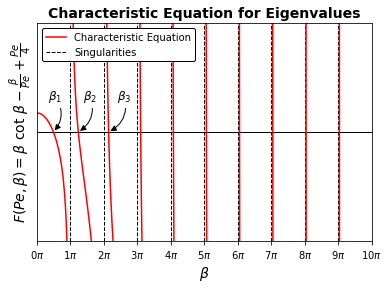

In [225]:
%matplotlib inline

# Define the characteristic equation function
def characteristic(Pe, beta):
    return beta * np.cos(beta) / np.sin(beta) - beta**2/Pe + Pe/4

# Compute the Peclet number
Pe = U * L / D

# Make a list of the first few singularities
singularities = [np.pi * i for i in range(11)]

# Make a customized plot area
fig, ax = plt.subplots()
ax.set_ylim(-10,10)
ax.set_xlim(0, np.pi * 10)
ax.axhline(y=0, c = 'k', lw = 1)
ax.set_xlabel(r'$\beta$', weight = 'bold', fontsize = 14)
ax.set_ylabel(r'$F(Pe, \beta)=\beta$ $\cot$ $\beta - \frac{\beta}{Pe} + \frac{Pe}{4}$', weight = 'bold', fontsize = 14)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks(singularities)
ax.set_xticklabels(['{}$\pi$'.format(i) for i in range(len(singularities))])
ax.set_title('Characteristic Equation for Eigenvalues', weight = 'bold', fontsize = 14)

# Go through each interval (n * pi through (n+1) * pi) to plot 
# the function and singularities
for i in range(len(singularities)-1):
    s1 = singularities[i]
    s2 = singularities[i+1]
    xs = np.arange(s1 + np.pi/100, s2, np.pi/100)
    ys = characteristic(Pe, xs)
    ax.plot(xs,ys, c = 'r', lw = 1.5)
    ax.axvline(x=s2, c = 'k', ls = '--', lw = 1)
    
# add an annotation to point out the first few betas
arrowprops={'arrowstyle':'-|>','connectionstyle':'arc3,rad=-.4','fc':'k'}
ax.annotate(r'$\beta_{1}$', xy = [1.54,0], xytext = [1,3], fontsize = 12, arrowprops = arrowprops)
ax.annotate(r'$\beta_{2}$', xy = [3.88,0], xytext = [4.3,3], fontsize = 12, arrowprops = arrowprops)
ax.annotate(r'$\beta_{3}$', xy = [6.72,0], xytext = [7.5,3], fontsize = 12, arrowprops = arrowprops)

# make a formatted manual legend
ls = [lines.Line2D([-1],[-1], c = 'r', lw = 1.5), 
      lines.Line2D([-1],[-1], c = 'k', ls = '--', lw = 1)]
labels = ['Characteristic Equation','Singularities']
leg = plt.legend(loc = 2, facecolor = 'white', framealpha = 1, handles = ls, labels = labels)
leg.get_frame().set_edgecolor('k')

The graph above shows the value of the function, the singularities that every $n\pi$, and the location of the first eigenvalue near $\beta = 1.54$. To use the model result, the first task is to identify the eigenvalue across each interval. 

Note that as $\beta$ becomes larger, it tends to approach the singularity. A very good first guess for the next value of $\beta$ each time is to assume it is $\pi$ larger than the last value. After computing the first ~10 or so values, it is reasonable to assume the rest are just $\pi$ more than the last. 

Also note that there is no way to get all the eigenvalues, since there are an infinite number. The number required for a good approximation decreases as time goes by, due to the negative exponential term. At the beginning ~100 or so is needed.

### Determining the eigenvalues
Scientific Python has an optimization library with a variety of methods to determine the root of a function. The example below uses [Brent's method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html#scipy.optimize.brentq), which requires a function of one variable and computes the root across an interval. The code below creates a list of intervals and then uses the method to find all the eigenvalues.

In [268]:
# Compute the Peclet number
Pe = U * L / D

# Define the characteristic equation function with only one argument
def characteristic(beta):
    return beta * np.cos(beta) / np.sin(beta) - beta**2/Pe + Pe/4

# Make a list of the intervals to look for each value of beta
intervals = [np.pi * i for i in range(n)]

# Store the eigenvalues in a list
betas = []

# iterate through the interval and find the beta value
for i in range(len(intervals)-1):
    mi = intervals[i]   + 10**-10
    ma = intervals[i+1] - 10**-10
    
    # Brent's method can find the value of the 
    # characteristic equation within a given interval
    betas.append(optimize.brentq(characteristic, mi, ma))

### Estimating the concentration profiles
Now that the eigenvalues have been determined, it is possible to evaluate the concentration at any point in time and space. The code below determines the concentration profiles across the column at different points in time.

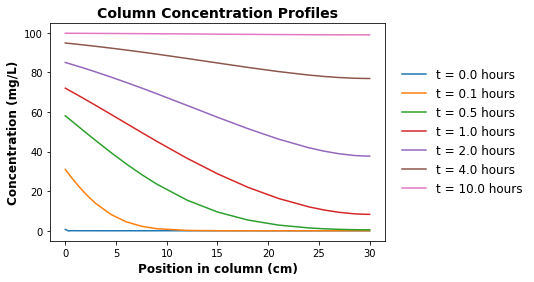

In [273]:
%matplotlib inline

# Define an array of x values to estimate the function
positions = L * np.array([0, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1,
                          0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 
                          0.7, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99, 1])

# Define an array time points to estimate the function
times = [0.00001, 0.1, 0.5, 1, 2, 4, 10]

# Define a function to use to compute the value of the "ith" term
# in the series of eigenfunctions that are summed in the solution
def eigenfunction(Pe, B, x, t):
    return (B * (B * np.cos(B * x) + Pe/2 * np.sin(B * x)) /
            (B**2 + Pe**2/4 + Pe) / (B**2 + Pe**2/4) * np.exp(-1 * B**2 * t)
           )

# Store the results at each x,t pair in a list of lists
Cs = []

# Estimate the concentration for each dimensionless time and x
for t in times:
    tau = D * t / L**2
    Cs.append([])
    for p in positions:
        x = p / L
        
        # Get the eigenfunction values for all the eigenvalues
        series = eigenfunction(Pe, np.array(betas), x, tau)
        
        # Sum the series and convert the result to concentration at the point
        C = C0 * (1 - 2 * Pe * np.exp(Pe/2 * x - Pe**2/4 * tau) * series.sum())
        Cs[-1].append(C)
        
# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel('Position in column (cm)', size = 12, weight = 'bold')
ax.set_ylabel('Concentration (mg/L)', size = 12, weight = 'bold')
ax.set_title('Column Concentration Profiles', size = 14, weight = 'bold')
for t,C in zip(times,Cs):
    ax.plot(positions,C, label = 't = {:.1f} hours'.format(t))
leg = ax.legend(bbox_to_anchor = (1.02, 0.5), loc = 6, fontsize = 12)
leg.get_frame().set_linewidth(0)

The figure shows the evolution in the concentration profile over time throughout the column. At the beginning, it is zero everywhere, as expected, while at the end, it has reached the influent concentration everywhere. Between these extremes, the concentration gradually breaks through the column.

### Calculating the concentration in the effluent
While it is interesting to plot the distribution of concentration throughout the column, the concentration at the outlet is what is of primary interest for tracer studies, since it can be compared to observed data. A high resolution time series of concentrations can easily be obtained by evaluating the function at the outlet ($x=L$) as shown below.

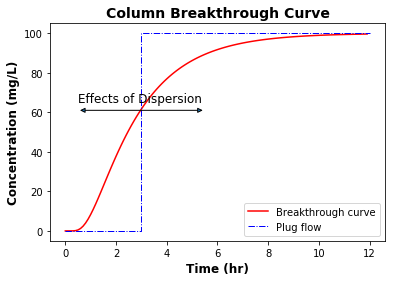

In [322]:
%matplotlib inline

# Define an array time points to estimate the function
times = np.arange(0,12,0.1)

# Define a function to use to compute the value of the "ith" term
# in the series of eigenfunctions that are summed in the solution
def eigenfunction(Pe, B, x, t):
    return (B * (B * np.cos(B * x) + Pe/2 * np.sin(B * x)) /
            (B**2 + Pe**2/4 + Pe) / (B**2 + Pe**2/4) * np.exp(-1 * B**2 * t)
           )

# Store the results in a list
Cs = []

# Estimate the concentration for each dimensionless time at x = 1
for t in times:
    tau = D * t / L**2
    x = 1
        
    # Get the eigenfunction values for all the eigenvalues
    series = eigenfunction(Pe, np.array(betas), x, tau)
        
    # Sum the series and convert the result to concentration at the point
    C = C0 * (1 - 2 * Pe * np.exp(Pe/2 * x - Pe**2/4 * tau) * series.sum())
    Cs.append(C)
        
# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel('Time (hr)', size = 12, weight = 'bold')
ax.set_ylabel('Concentration (mg/L)', size = 12, weight = 'bold')
ax.set_title('Column Breakthrough Curve', size = 14, weight = 'bold')
ax.plot(times, Cs, ls = '-', c = 'r', label = 'Breakthrough curve')

# Add a couple of other lines for explanation of behavior
xs = [0, L/U, L/U, 12]
ys = [0, 0, C0, C0]
ax.plot(xs, ys, ls = '-.', lw = 1, c = 'b', label = 'Plug flow')
ax.text(0.5,65,'Effects of Dispersion', fontsize = 12)
arrowprops = {'arrowstyle':'<|-|>'}
ax.annotate('', xy = (5.5,61), xytext = (0.5,61), ha = 'right', va = 'center', arrowprops = arrowprops)
leg = ax.legend()

The dispersion in the column caused by differences in flow path lengths acts to broaden the breakthrough curve of the tracer compared with ideal plug flow. 

### Dispersion model fitting
The model is useful for fitting values of dispersion coefficients to observations of the concentration in the effluent. In this case, the model must be run repeatedly at different values of $D$ to meet some fitness criteron, such as minimizing the total squared error.